# Load Packages and Data

In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [179]:
portfolio = pd.read_json(r'data\01_raw\portfolio.json', lines=True)
profile = pd.read_json(r'data\01_raw\profile.json', lines=True)
transcript = pd.read_json(r'data\01_raw\transcript.json', lines=True)

# Portfolio Data

In [180]:
"""
portfolio.json
Offers sent during 30-day test period (10 offers x 6 fields)
    id (string) - offer id
    offer_type (string) - type of offer ie BOGO, discount, informational
    difficulty (int) - minimum required spend to complete an offer
    reward (int) - reward given for completing an offer
    duration (int) - time for offer to be open, in days
    channels (list of strings)
"""

# Load each JSON file into a pandas DataFrame
portfolio = pd.read_json(r'data\01_raw\portfolio.json', lines=True)
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


## Featurize the 'channels' column

In [181]:
# Convert 'channels' column into a string of space-separated strings
portfolio['channels'] = portfolio['channels'].apply(lambda x: ' '.join(x))

# Convert 'channels' column into separate binary columns
channels_profile = portfolio['channels'].str.get_dummies(' ')

# Concatenate the original DataFrame with the new 'channels' DataFrame
portfolio = pd.concat([portfolio, channels_profile], axis=1)

# Drop the original 'channels' column
portfolio = portfolio.drop('channels', axis=1)

# Rename the 'id' column to 'offer_id'
portfolio = portfolio.rename(columns={'id': 'offer_id'})

portfolio.head()

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1


## Summary

In [182]:
#Count of offer_ids
num_offers = portfolio['offer_id'].nunique()

#Count of offer types
offer_types = portfolio['offer_type'].nunique()

#Create a list of offer types
offer_type_list = portfolio['offer_type'].unique()

#Convert to a offer_type_list to a string
offer_type_list = ', '.join(offer_type_list)

print("The dataset contains {} unique offers that consists of {} different offer types: {}.".
      format(num_offers, offer_types, offer_type_list))

print("The offers were sent through email, mobile, social and web channels.")

#Min and Max difficulty
min_difficulty = portfolio['difficulty'].min()
max_difficulty = portfolio['difficulty'].max()

#Min and Max reward
min_reward = portfolio['reward'].min()
max_reward = portfolio['reward'].max()

print("Customers were prompted to spend from {} to {} dollars with the rewards ranging from {} to {} dollars"
      .format(min_difficulty, max_difficulty, min_reward, max_reward))

The dataset contains 10 unique offers that consists of 3 different offer types: bogo, informational, discount.
The offers were sent through email, mobile, social and web channels.
Customers were prompted to spend from 0 to 20 dollars with the rewards ranging from 0 to 10 dollars


## Featurize offer_types

In [183]:
# Convert the offer_type column into separate binary columns
offer_type_profile = pd.get_dummies(portfolio['offer_type'], prefix='offer_type')

# Convert True/False values to 1/0
offer_type_profile = offer_type_profile.astype(int)

# Concatenate the original DataFrame with the new 'offer_type' DataFrame
portfolio = pd.concat([portfolio, offer_type_profile], axis=1)

# Drop the original 'offer_type' column
portfolio = portfolio.drop('offer_type', axis=1)
portfolio.head()

,reward,difficulty,duration,offer_id,email,mobile,social,web,offer_type_bogo,offer_type_discount,offer_type_informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0


## Graph offer_types and channels

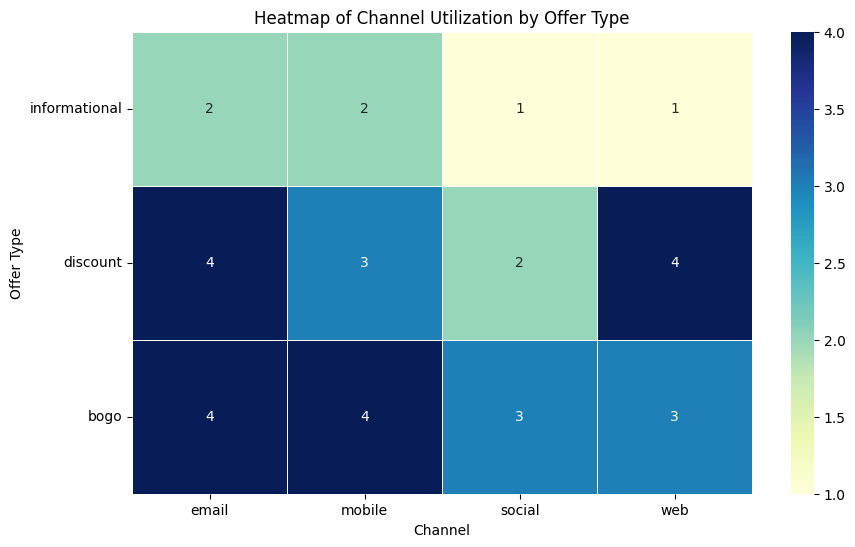

In [184]:
# Create a new DataFrame to summarize the channel utilization by offer type
channel_utilization = portfolio[['offer_type_bogo', 'offer_type_discount', 'offer_type_informational', 'email', 'mobile', 'social', 'web']]

# Group by offer type and sum the channels
channel_utilization_summary = channel_utilization.groupby(['offer_type_bogo', 'offer_type_discount', 'offer_type_informational']).sum()

# Reset index to make the DataFrame easier to handle
channel_utilization_summary.reset_index(inplace=True)

# Map offer type columns to a single 'offer_type' column for easier plotting
channel_utilization_summary['offer_type'] = channel_utilization_summary.apply(
    lambda row: 'bogo' if row['offer_type_bogo'] == 1 else ('discount' if row['offer_type_discount'] == 1 else 'informational'), axis=1)

# Drop the offer type indicator columns
channel_utilization_summary.drop(columns=['offer_type_bogo', 'offer_type_discount', 'offer_type_informational'], inplace=True)

# Set 'offer_type' as the index
channel_utilization_summary.set_index('offer_type', inplace=True)

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(channel_utilization_summary, annot=True, cmap='YlGnBu', fmt='d', linewidths=.5)

plt.title('Heatmap of Channel Utilization by Offer Type')
plt.xlabel('Channel')
plt.ylabel('Offer Type')

# Rotate y-axis labels
plt.yticks(rotation=0)

plt.show()

## Export Featurized Data

In [185]:
#Export the cleaned data to .csv
portfolio.to_csv(r'data\02_staging\stg_portfolio.csv', index=False)

#Pickle the cleaned data
portfolio.to_pickle(r'data\02_staging\stg_portfolio.pkl')

# Profile Data

In [186]:
"""
profile.json
Rewards program users (17000 users x 5 fields)
Details the different offers sent during the test period, including offer type (buy-one-get-one, discount, informational), reward amount, required spending threshold, duration, and delivery channels.
    age (int) - age of the customer (missing value is encoded as 118)
    became_member_on (int) - date when customer created an app account
    gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
    id (str) - customer id
    income (float) - customer's income

"""
# Rename the 'id' column to 'customer_id'
profile = profile.rename(columns={'id': 'customer_id'})

#Convert 'became_member_on' to datetime
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

profile.head()

,gender,age,customer_id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN


## Standardize Null Values

In [187]:
# Replace None with NaN
profile['gender'] = profile['gender'].fillna(np.nan)

# Replace 118 with NaN
profile['age'] = profile['age'].replace(118, np.nan)

profile.head()

,gender,age,customer_id,became_member_on,income
0,NaN,NaN,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
2,NaN,NaN,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
4,NaN,NaN,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN


## Summary

### Data Density

In [188]:
nan_percent = round(profile.isna().mean() * 100, 2)
print(nan_percent)

gender              12.79
age                 12.79
customer_id          0.00
became_member_on     0.00
income              12.79
dtype: float64


### Data Distributions

In [189]:
#Calculate the date range for profile['become_member_on']
min_date = profile['became_member_on'].min()
max_date = profile['became_member_on'].max()
print("The customers became members between {} and {}.".format(min_date.strftime('%B %d, %Y'), max_date.strftime('%B %d, %Y')))

#Calculate the number of men in the data set
num_men = profile[profile['gender'] == 'M']['gender'].count()
num_women = profile[profile['gender'] == 'F']['gender'].count()
print("There are {} men in the dataset".format(num_men))
print("There are {} women in the dataset".format(num_women))

The customers became members between July 29, 2013 and July 26, 2018.
There are 8484 men in the dataset
There are 6129 women in the dataset


In [190]:
profile['age'].describe()

count    14825.000000
mean        54.393524
std         17.383705
min         18.000000
25%         42.000000
50%         55.000000
75%         66.000000
max        101.000000
Name: age, dtype: float64

In [191]:
# Calculate descriptive statistics
income_desc = profile['income'].describe()

# Convert to DataFrame
income_desc = pd.DataFrame(income_desc)

# Format 'income' column with commas
income_desc['income'] = income_desc['income'].map('{:,.2f}'.format)

# Print the result
income_desc

,income
count,"14,825.00"
mean,"65,404.99"
std,"21,598.30"
min,"30,000.00"
25%,"49,000.00"
50%,"64,000.00"
75%,"80,000.00"
max,"120,000.00"


## Featurize Data

Note: I need to figure out what I'm going to do with the missing data here. I need to do this for the demographic information

In [192]:
# Extract date parts
profile['membership_year'] = profile['became_member_on'].dt.year
profile['membership_month'] = profile['became_member_on'].dt.month
profile['membership_day'] = profile['became_member_on'].dt.day

# Calculate membership duration in days
current_date = pd.Timestamp('2024-05-29')  # Example current date
profile['membership_duration_days'] = (current_date - profile['became_member_on']).dt.days


### Demographic Cleaning ###

# One-hot encoding for gender
profile = pd.get_dummies(profile, columns=['gender'], dummy_na=True)

# Handle missing values in 'age'
profile['age'] = profile['age'].fillna(-1)  # Use -1 as a placeholder for missing values

# Bin ages into life stages
bins = [18, 25, 35, 45, 55, 65, 102]
labels = [f'{i+1}-{j}' for i, j in zip(bins[:-1], bins[1:])]
profile['age_group'] = pd.cut(profile['age'], bins=bins, labels=labels, right=False)

# One-hot encode 'age_group'
profile = pd.get_dummies(profile, columns=['age_group'])

# Handle missing values in 'income'
profile['income'] = profile['income'].fillna(profile['income'].median())



# Drop 'become_member_on' column because it is no longer needed
profile.drop(columns=['became_member_on'], inplace=True)

# Display the transformed DataFrame
profile.head()

,age,customer_id,income,membership_year,membership_month,membership_day,membership_duration_days,gender_F,gender_M,gender_O,gender_nan,age_group_19-25,age_group_26-35,age_group_36-45,age_group_46-55,age_group_56-65,age_group_66-102
0,-1.0,68be06ca386d4c31939f3a4f0e3dd783,64000.0,2017,2,12,2663,False,False,False,True,False,False,False,False,False,False
1,55.0,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,15,2510,True,False,False,False,False,False,False,False,True,False
2,-1.0,38fe809add3b4fcf9315a9694bb96ff5,64000.0,2018,7,12,2148,False,False,False,True,False,False,False,False,False,False
3,75.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,9,2577,True,False,False,False,False,False,False,False,False,True
4,-1.0,a03223e636434f42ac4c3df47e8bac43,64000.0,2017,8,4,2490,False,False,False,True,False,False,False,False,False,False


In [193]:
#Export the cleaned data to .csv
profile.to_csv(r'data\02_staging\stg_profile.csv', index=False)

#Pickle the cleaned data
profile.to_pickle(r'data\02_staging\stg_profile.pkl')

# Transcript Data

In [194]:
"""
Event log (306648 events x 4 fields)
Logs all events related to offers and transactions, such as offer receipt, offer view, transaction amount, and offer completion, along with timestamps
    event (str) - record description (ie transaction, offer received, offer viewed, etc.)
    person (str) - customer id
    time (int) - time in hours since start of test. The data begins at time t=0
    value - (dict of strings) - either an offer id or transaction amount depending on the record

"""
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
